In [1]:
import pandas as pd
import requests
import io
import sqlite3
# import matplotlib as plt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PooledOLS
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Part 1: getting the data

## 1.a: describe url's from which the needed data will be downloaded:

In [ ]:
umpl_url = 'https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HUR.TOT.PC_LF.M/OECD?contentType=csv&detail=code&separator=comma&csv-lang=en&startPeriod=1990'
cpi_url = 'https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CPI.TOT.AGRWTH.M/OECD?contentType=csv&detail=code&separator=comma&csv-lang=en&startPeriod=1990'
ltint_url = 'https://stats.oecd.org/sdmx-json/data/DP_LIVE/.LTINT.TOT.PC_PA.M/OECD?contentType=csv&detail=code&separator=comma&csv-lang=en&startPeriod=1990'
# BCI - Business confidence index
bci_url = 'https://stats.oecd.org/sdmx-json/data/DP_LIVE/.BCI.AMPLITUD.LTRENDIDX.M/OECD?contentType=csv&detail=code&separator=comma&csv-lang=en&startPeriod=1990'
# CCI - Consumer confidence index
cci_url = 'https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CCI.AMPLITUD.LTRENDIDX.M/OECD?contentType=csv&detail=code&separator=comma&csv-lang=en&startPeriod=1990'
''

## 1.b: create sql database that will hold the data and establish the connection:

In [2]:
conn = sqlite3.connect('/Users/markrozenberg/Downloads/Macro-Indicators/macro_indicators.db')

## 1.c: function to read data from url and store in the database:

In [5]:
def read_data(url, indic):
    cont = requests.get(url).content
    data = pd.read_csv(io.StringIO(cont.decode('utf-8')))
    data.to_sql(indic, conn)

# execute the function for our data:
read_data(umpl_url, 'umpl')
read_data(cpi_url, 'cpi')
read_data(ltint_url, 'ltint')
read_data(bci_url, 'bci')
read_data(cci_url, 'cci')

## 1.d: combine the tables into one combined

In [110]:
q_drop_comb = ''' drop table if exists comb_data '''
conn.execute(q_drop_comb)

query = '''
create table comb_data as
with
t1 as(select location, time, value as umpl from umpl),
t2 as(select location, time, value as cpi from cpi),
t3 as(select location, time, value as ltint from ltint),
t4 as(select location, time, value as bci from bci),
t5 as(select location, time, value as cci from cci)
select
coalesce(t1.location, t2.location, t3.location, t4.location, t5.location) as location,
coalesce(t1.time, t2.time, t3.time, t4.time, t5.time) as time,
t1.umpl, t2.cpi, t3.ltint, t4.bci, t5.cci
from t1
join t2
on t1.location = t2.location and t1.time = t2.time
join t3
on t1.location = t3.location and t1.time = t3.time
join t4
on t1.location = t4.location and t1.time = t4.time
join t5
on t1.location = t5.location and t1.time = t5.time
'''
conn.execute(query)

## 1.e: create additional table with 3 months lag for each independent variables (features):

In [123]:
conn.execute('''drop table if exists comb_data_with_lag ''')
conn.execute('''
create table comb_data_with_lag as
select location, time, ltint, umpl, cpi, bci, cci,
lag(umpl) over(partition by location order by cast(time as date)) as lag_umpl,
lag(cpi) over(partition by location order by cast(time as date)) as lag_cpi,
lag(bci) over(partition by location order by cast(time as date)) as lag_bci, 
lag(cci) over(partition by location order by cast(time as date)) as lag_cci,
lag(umpl,2) over(partition by location order by cast(time as date)) as lag2_umpl,
lag(cpi,2) over(partition by location order by cast(time as date)) as lag2_cpi, 
lag(bci,2) over(partition by location order by cast(time as date)) as lag2_bci, 
lag(cci,2) over(partition by location order by cast(time as date)) as lag2_cci,
lag(umpl,3) over(partition by location order by cast(time as date)) as lag3_umpl,
lag(cpi,3) over(partition by location order by cast(time as date)) as lag3_cpi, 
lag(bci,3) over(partition by location order by cast(time as date)) as lag3_bci, 
lag(cci,3) over(partition by location order by cast(time as date)) as lag3_cci 
from comb_data
''')

In [124]:
check = pd.read_sql_query("select * from comb_data_with_lag limit 10", conn)
check

,location,time,ltint,umpl,cpi,bci,cci,lag_umpl,lag_cpi,lag_bci,lag_cci,lag2_umpl,lag2_cpi,lag2_bci,lag2_cci,lag3_umpl,lag3_cpi,lag3_bci,lag3_cci
0,AUT,1993-01,7.2235,3.8,4.101749,97.02708,100.18930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AUT,1993-02,7.1308,3.8,3.716536,96.78777,100.00170,3.8,4.101749,97.02708,100.18930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AUT,1993-03,6.8580,3.9,3.831659,96.70801,99.81452,3.8,3.716536,96.78777,100.00170,3.8,4.101749,97.02708,100.18930,NaN,NaN,NaN,NaN
3,AUT,1993-04,6.9251,3.9,3.831659,96.73418,99.68923,3.9,3.831659,96.70801,99.81452,3.8,3.716536,96.78777,100.00170,3.8,4.101749,97.02708,100.18930
4,AUT,1993-05,7.0583,4.0,3.694427,96.80978,99.78412,3.9,3.831659,96.73418,99.68923,3.9,3.831659,96.70801,99.81452,3.8,3.716536,96.78777,100.00170
5,AUT,1993-06,6.9902,4.0,3.588145,96.95176,99.96413,4.0,3.694427,96.80978,99.78412,3.9,3.831659,96.73418,99.68923,3.9,3.831659,96.70801,99.81452
6,AUT,1993-07,6.7500,4.0,3.514180,97.14076,100.04960,4.0,3.588145,96.95176,99.96413,4.0,3.694427,96.80978,99.78412,3.9,3.831659,96.73418,99.68923
7,AUT,1993-08,6.6043,4.1,3.438748,97.28169,99.98024,4.0,3.514180,97.14076,100.04960,4.0,3.588145,96.95176,99.96413,4.0,3.694427,96.80978,99.78412
8,AUT,1993-09,6.4350,4.0,3.400309,97.49335,99.90091,4.1,3.438748,97.28169,99.98024,4.0,3.514180,97.14076,100.04960,4.0,3.588145,96.95176,99.96413
9,AUT,1993-10,6.2644,4.0,3.467492,97.84779,100.05970,4.0,3.400309,97.49335,99.90091,4.1,3.438748,97.28169,99.98024,4.0,3.514180,97.14076,100.04960


# Part 2: tests and checks for the data

## part 2.a: checks using aggregations

In [8]:
check_q = '''
select 'umpl' as source, count(*) as freq,
count(distinct location) as count_location,
min(time) as min_time,
max(time) as max_time
from umpl where value is not null
union
select 'cpi' as source, count(*) as freq,
count(distinct location) as count_location,
min(time) as min_time,
max(time) as max_time
from cpi where value is not null
union
select 'ltint' as source, count(*) as freq,
count(distinct location) as count_location,
min(time) as min_time,
max(time) as max_time
from ltint where value is not null
union
select 'bci' as source, count(*) as freq,
count(distinct location) as count_location,
min(time) as min_time,
max(time) as max_time
from bci where value is not null
union
select 'cci' as source, count(*) as freq,
count(distinct location) as count_location,
min(time) as min_time,
max(time) as max_time
from cci where value is not null
'''
check = pd.read_sql(check_q, con=conn)
print(check)

  source   freq  count_location min_time max_time
0    bci  18099              49  1990-01  2023-08
1    cci  17105              49  1990-01  2023-08
2    cpi  18840              49  1990-01  2023-07
3  ltint  14803              47  1990-01  2023-07
4   umpl  13961              40  1990-01  2023-07


In [111]:
# check = pd.read_sql_query("select * from comb_data where umpl is null or cpi is null or ltint is null", conn)
check = pd.read_sql_query("select * from comb_data limit 3", conn)
check

,location,time,umpl,cpi,ltint,bci,cci
0,AUT,1993-01,3.8,4.101749,7.2235,97.02708,100.18930
1,AUT,1993-02,3.8,3.716536,7.1308,96.78777,100.00170
2,AUT,1993-03,3.9,3.831659,6.8580,96.70801,99.81452


In [18]:
check = pd.read_sql_query("select distinct location from comb_data", conn)
check

   location
0       AUT
1       BEL
2       CZE
3       DNK
4       FIN
5       FRA
6       DEU
7       GRC
8       HUN
9       IRL
10      ITA
11      JPN
12      KOR
13      LUX
14      MEX
15      NLD
16      POL
17      PRT
18      SVK
19      ESP
20      SWE
21      GBR
22      USA
23      CHL
24      EST
25      ISR
26      SVN
27      LVA
28      LTU
29      COL
30      CRI


In [81]:
check = pd.read_sql_query("select location, "
"count(umpl) as count_umpl "
"from comb_data "
"group by 1 "
"order by 2", conn)
check

,location,count_umpl
0,EST,37
1,CRI,114
2,ISR,138
3,COL,198
4,MEX,205
5,CHL,216
6,SVN,256
7,LUX,258
8,LTU,266
9,LVA,266


## part 2.b: graphical exploration (i will use subset of countries)

In [203]:
dat_for_graph = pd.read_sql_query("select * from comb_data "
"where location in('ISR','IRL','USA','JPN','GBR','DNK','ESP','FRA') "
"and cast(substr(time,1,4) as int) > 2010", conn)

<Axes: xlabel='time'>

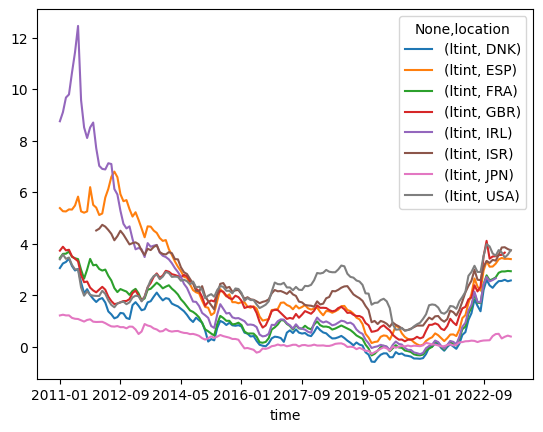

In [207]:
# graph-1:
pd.pivot_table(dat_for_graph.reset_index(),
   index='time', columns='location', values=['ltint']
  ).plot(legend=True)

<Axes: xlabel='time'>

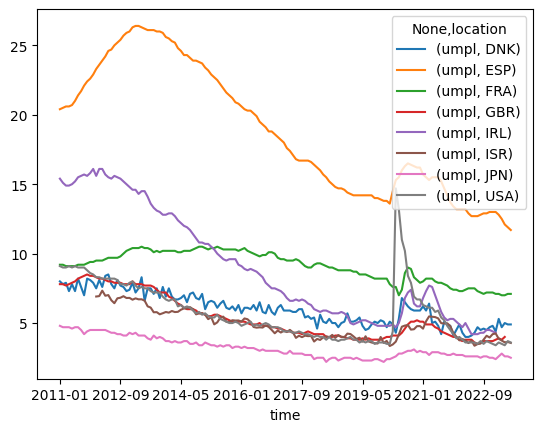

In [208]:
# graph-2:
pd.pivot_table(dat_for_graph.reset_index(),
   index='time', columns='location', values=['umpl']
  ).plot(legend=True)

<Axes: xlabel='time'>

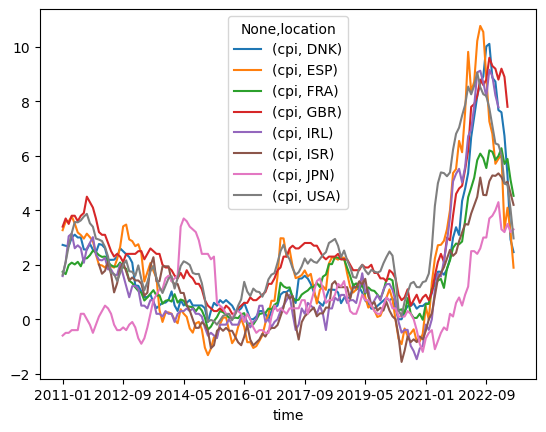

In [209]:
# graph-3:
pd.pivot_table(dat_for_graph.reset_index(),
   index='time', columns='location', values=['cpi']
  ).plot(legend=True)

<Axes: xlabel='time'>

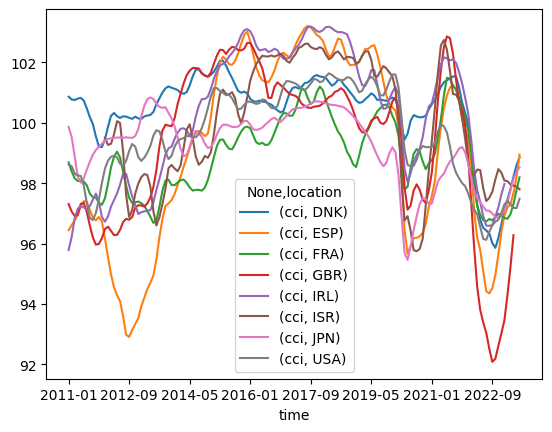

In [210]:
# graph-4:
pd.pivot_table(dat_for_graph.reset_index(),
   index='time', columns='location', values=['cci']
  ).plot(legend=True)

<Axes: xlabel='time'>

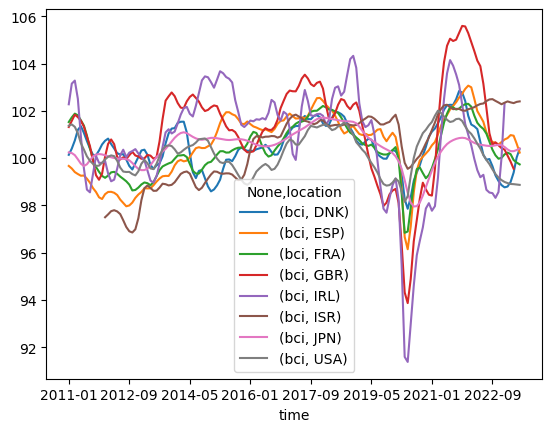

In [211]:
# graph-5:
pd.pivot_table(dat_for_graph.reset_index(),
   index='time', columns='location', values=['bci']
  ).plot(legend=True)

## part 2.c: correlation matrix


In [54]:
dest = '/Users/markrozenberg/Downloads/'
pd.DataFrame(dat_for_graph.corr()).to_excel(dest + 'CorrMatrix.xlsx')

## part 2.d: check and select for list of countries with biggest amount of data

In [212]:
check = pd.read_sql_query(
"select location, min(time) "
"from comb_data "
"where umpl is not null and cpi is not null and ltint is not null "
"and bci is not null and cci is not null "
"group by 1 "
"order by 2", conn)
print(check)

   location min(time)
0       BEL   1990-01
1       DNK   1990-01
2       ESP   1990-01
3       FRA   1990-01
4       GBR   1990-01
5       IRL   1990-01
6       JPN   1990-01
7       NLD   1990-01
8       USA   1990-01
9       DEU   1991-01
10      ITA   1991-03
11      AUT   1993-01
12      FIN   1993-01
13      PRT   1993-07
14      SWE   1996-01
15      GRC   1998-04
16      HUN   1999-02
17      CZE   2000-04
18      SVK   2000-09
19      KOR   2000-10
20      LTU   2001-05
21      LVA   2001-05
22      POL   2001-05
23      MEX   2001-07
24      LUX   2002-01
25      SVN   2002-03
26      CHL   2004-07
27      COL   2007-01
28      CRI   2011-08
29      ISR   2012-01
30      EST   2020-06


## Part 3: Preparing data for forecasting

## part 3.a: select the data for the target countries

In [3]:
dat_for_analysis = pd.read_sql_query(
"select * "
"from comb_data_with_lag "
"where location in('IRL','USA','JPN','GBR','DNK','ESP','FRA') " , conn)
print(dat_for_analysis.shape)
print(dat_for_analysis.columns)

(2807, 19)


## part 3.b: pivot the data
### note: each combination of country and parameter will be in separate columns

In [4]:
dat_for_analysis_pivot = pd.pivot_table(dat_for_analysis,
values=['ltint','umpl','cpi','bci','cci',
        'lag_umpl','lag_cpi', 'lag_bci', 'lag_cci',
        'lag2_umpl', 'lag2_cpi', 'lag2_bci', 'lag2_cci',
        'lag3_umpl', 'lag3_cpi', 'lag3_bci', 'lag3_cci'],
index=['time'],
columns=['location'], aggfunc="max")
# transform column names from tuple to string
dat_for_analysis_pivot.columns = ['_'.join(x) for x in dat_for_analysis_pivot.columns]
dat_for_analysis_pivot = dat_for_analysis_pivot.reset_index()
# drop rows with null's:
dat_for_analysis_pivot = dat_for_analysis_pivot.dropna()
print(dat_for_analysis_pivot.shape)
dat_for_analysis_pivot.head()

,time,bci_DNK,bci_ESP,bci_FRA,bci_GBR,bci_IRL,bci_JPN,bci_USA,cci_DNK,cci_ESP,...,ltint_IRL,ltint_JPN,ltint_USA,umpl_DNK,umpl_ESP,umpl_FRA,umpl_GBR,umpl_IRL,umpl_JPN,umpl_USA
3,1990-04,99.37424,99.32653,101.0472,99.23208,100.9098,102.8364,99.24118,99.28437,101.8785,...,10.556790,6.906,8.79,7.0,15.6,9.4,6.8,13.2,2.1,5.4
4,1990-05,99.15978,98.98381,100.9823,99.20673,100.7922,102.7679,99.16409,99.13715,101.9060,...,10.363740,6.508,8.76,7.1,15.6,9.4,6.7,13.2,2.1,5.4
5,1990-06,99.08552,98.92554,100.9586,99.04725,100.7302,102.7156,98.96852,98.92982,102.0425,...,10.191010,6.421,8.48,7.1,15.5,9.4,6.7,13.2,2.2,5.2
6,1990-07,99.09319,98.82505,100.7780,98.66767,100.5919,102.7007,98.65776,98.82326,102.0416,...,9.835391,6.772,8.47,7.2,15.3,9.3,6.8,13.2,2.1,5.5
7,1990-08,99.08381,98.66882,100.2747,98.20588,100.0806,102.7073,98.35481,98.81305,101.5575,...,10.465340,7.620,8.75,7.2,15.3,9.3,6.8,13.3,2.0,5.7


## part 3.c: split into train and test

In [215]:
train = dat_for_analysis_pivot[dat_for_analysis_pivot['time'] <= '2015-01']
test = dat_for_analysis_pivot[dat_for_analysis_pivot['time'] > '2015-01']
train = train.set_index('time')
test = test.set_index('time')
train.dropna()
test.dropna()
print(train.shape)
print(test.shape)
print('train start: ', min(list(train.index)))
print('train end: ', max(list(train.index)))
print('test start: ', min(list(test.index)))
print('test end: ', max(list(test.index)))

(298, 119)
(96, 119)
train start:  1990-04
train end:  2015-01
test start:  2015-02
test end:  2023-01


## part 3.d: split train and test data into x and y

In [84]:
# choose the country for which we will do the analysis
test_count = 'JPN'
y_train = train[['ltint_' + test_count]]
x_train = train[[c for c in train.columns if c not in ['ltint_' + test_count]]]
x_test = test[[c for c in test.columns if c not in ['ltint_' + test_count]]]
y_test = test[['ltint_' + test_count]]
# drop time columns:
# x_train = x_train.drop(columns=['time'])
# x_test = x_test.drop(columns=['time'])
print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)
list(x_train.columns) == list(x_test.columns)

(298, 1)
(298, 118)
(96, 1)
(96, 118)


# part 4: Forecasting models

In [96]:
# this table will hold the testing metrics from the various models
# del Compare_Table
Compare_Table = pd.DataFrame(columns=['Model','MAE','MSE','EVS','COD'])

## part 4.a: Version 1 - Linear Regression with full set of features

In [97]:
reg = LinearRegression().fit(x_train, y_train)
forec_Mod1 = reg.predict(x_test)
# print(reg.coef_)
# print(reg.intercept_)
# print(reg.score(x_train, y_train))
new_row = pd.DataFrame([{'Model': 'LR with features',
                                      'MAE':mean_absolute_error(y_test, forec_Mod1),
                                      'MSE':mean_squared_error(y_test, forec_Mod1),
                                      'EVS':explained_variance_score(y_test, forec_Mod1),
                                      'COD':r2_score(y_test, forec_Mod1)}])
Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)

/var/folders/sw/ww6lxt_s0m1g67d84tph_w640000gn/T/ipykernel_69426/2055010475.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)


## part 4.b: Version 2 - Sarimax with full set of features

In [98]:
ARMAmodel = SARIMAX(y_train, order = (1, 1, 1), exog=x_train).fit()
# forec_Mod2 = ARMAmodel.predict(start = y_test.index[0], end = y_test.index[0], exog=x_test)
forec_Mod2 = ARMAmodel.predict(start = '2015-02', end = '2023-01', exog=x_test)
new_row = pd.DataFrame([{'Model': 'Sarimax with features',
                                      'MAE':mean_absolute_error(y_test, forec_Mod2),
                                      'MSE':mean_squared_error(y_test, forec_Mod2),
                                      'EVS':explained_variance_score(y_test, forec_Mod2),
                                      'COD':r2_score(y_test, forec_Mod2)}])
Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)

/Users/markrozenberg/zesty/cur-data-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/markrozenberg/zesty/cur-data-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          121     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.13715D-01    |proj g|=  5.69403D-01

At iterate    5    f= -7.16026D-01    |proj g|=  1.30718D-01

At iterate   10    f= -7.18724D-01    |proj g|=  6.69940D-02

At iterate   15    f= -7.20347D-01    |proj g|=  7.30472D-02

At iterate   20    f= -7.22990D-01    |proj g|=  5.08838D-02

At iterate   25    f= -7.24748D-01    |proj g|=  2.42340D-01

At iterate   30    f= -7.26762D-01    |proj g|=  1.75495D-02

At iterate   35    f= -7.28766D-01    |proj g|=  2.29577D-02

At iterate   40    f= -7.30058D-01    |proj g|=  1.45214D-02

At iterate   45    f= -7.32040D-01    |proj g|=  3.03853D-02

At iterate   50    f= -7.33406D-01    |proj g|=  1.15907D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/markrozenberg/zesty/cur-data-analysis/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [99]:
Compare_Table

,Model,MAE,MSE,EVS,COD
0,LR with features,0.911111,1.230462,-30.027379,-48.167302
1,Sarimax with features,0.573486,0.550662,-18.832323,-21.003570


## part 4.c: reduce number of features using elimination technique:

In [168]:
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import linear_model

# Perform stepwise regression: for best subset of indepndent variables
sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                k_features=(2,60),
                                forward=True,
                                scoring='neg_root_mean_squared_error',
                                cv=0)
selected_features = sfs.fit(x_train, y_train)

best combination (ACC: -0.147): (5, 6, 9, 10, 11, 12, 13, 15, 16, 18, 20, 24, 27, 29, 33, 36, 37, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 59, 60, 63, 66, 67, 68, 70, 71, 73, 74, 75, 76, 79, 81, 82, 83, 90, 93, 95, 96, 97, 99, 107, 108, 109, 110, 112, 113, 114, 115, 117)

best features names:  ('bci_JPN', 'bci_USA', 'cci_FRA', 'cci_GBR', 'cci_IRL', 'cci_JPN', 'cci_USA', 'cpi_ESP', 'cpi_FRA', 'cpi_IRL', 'cpi_USA', 'lag2_bci_GBR', 'lag2_bci_USA', 'lag2_cci_ESP', 'lag2_cci_JPN', 'lag2_cpi_ESP', 'lag2_cpi_FRA', 'lag2_umpl_ESP', 'lag2_umpl_FRA', 'lag2_umpl_GBR', 'lag2_umpl_IRL', 'lag2_umpl_JPN', 'lag2_umpl_USA', 'lag3_bci_DNK', 'lag3_bci_ESP', 'lag3_bci_GBR', 'lag3_bci_IRL', 'lag3_bci_JPN', 'lag3_bci_USA', 'lag3_cci_GBR', 'lag3_cci_IRL', 'lag3_cpi_DNK', 'lag3_cpi_GBR', 'lag3_cpi_IRL', 'lag3_cpi_JPN', 'lag3_umpl_DNK', 'lag3_umpl_ESP', 'lag3_umpl_GBR', 'lag3_umpl_IRL', 'lag3_umpl_JPN', 'lag3_umpl_USA', 'lag_bci_FRA', 'lag_bci_IRL', 'lag_bci_JPN', 'lag_bci_USA', 'lag_cci_USA', 'lag_cpi_

/Users/markrozenberg/zesty/cur-data-analysis/venv/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/markrozenberg/zesty/cur-data-analysis/venv/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

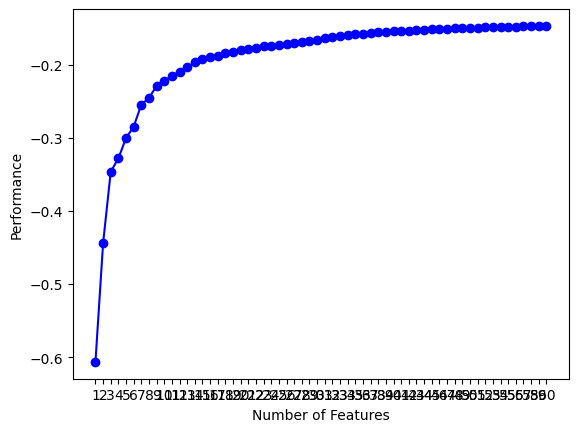

In [217]:
# print('best selection number of vars:', len(selected_features.k_feature_names_))
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
print('best features names: ', sfs.k_feature_names_)
plot_sfs(sfs.get_metric_dict(), kind='std_err')

### k highest scores feature selection, i do not used this technique 

In [139]:
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
# x_train_v3 = SelectKBest(f_classif, k=60).fit_transform(x_train, y_train)
SKB = SelectKBest(f_classif, k=60)
x_train_v3 = SKB.fit_transform(x_train, y_train)
print(x_train.shape)
print(x_train_v3.shape)

(298, 118)
(298, 60)


/Users/markrozenberg/zesty/cur-data-analysis/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [194]:
x_test_v2 = x_test[list(sfs.k_feature_names_)]
x_train_v2 = x_train[list(sfs.k_feature_names_)]
print(x_test_v2.shape)
print(x_train_v2.shape)

(96, 60)
(298, 60)


## part 4.d: Version 3 - Linear Regression with reduced form of features

In [196]:
reg = LinearRegression().fit(x_train_v2, y_train)
forec_Mod3 = reg.predict(x_test_v2)
# print(reg.coef_)
# print(reg.intercept_)
# print(reg.score(x_train, y_train))
new_row = pd.DataFrame([{'Model': 'LR with features reduced form',
                                      'MAE':mean_absolute_error(y_test, forec_Mod3),
                                      'MSE':mean_squared_error(y_test, forec_Mod3),
                                      'EVS':explained_variance_score(y_test, forec_Mod3),
                                      'COD':r2_score(y_test, forec_Mod3)}])
Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)

## part 4.e: Version 4 - Sarimax with reduced form of features

In [197]:
ARMAmodel = SARIMAX(y_train, order = (1, 1, 1), exog=x_train_v2).fit()
forec_Mod4 = ARMAmodel.predict(start = '2015-02', end = '2023-01', exog=x_test_v2)
new_row = pd.DataFrame([{'Model': 'Sarimax with features reduced form',
                                      'MAE':mean_absolute_error(y_test, forec_Mod4),
                                      'MSE':mean_squared_error(y_test, forec_Mod4),
                                      'EVS':explained_variance_score(y_test, forec_Mod4),
                                      'COD':r2_score(y_test, forec_Mod4)}])
Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)

/Users/markrozenberg/zesty/cur-data-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/markrozenberg/zesty/cur-data-analysis/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           63     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.87922D-01    |proj g|=  9.44858D-01


 This problem is unconstrained.



At iterate    5    f= -5.91912D-01    |proj g|=  1.16689D-01

At iterate   10    f= -5.93108D-01    |proj g|=  3.59401D-02

At iterate   15    f= -5.97569D-01    |proj g|=  7.63777D-02

At iterate   20    f= -6.01531D-01    |proj g|=  4.21156D-02

At iterate   25    f= -6.07309D-01    |proj g|=  2.90442D-02

At iterate   30    f= -6.09686D-01    |proj g|=  6.96576D-02

At iterate   35    f= -6.12674D-01    |proj g|=  2.40464D-02

At iterate   40    f= -6.14443D-01    |proj g|=  3.04587D-02

At iterate   45    f= -6.14700D-01    |proj g|=  1.76891D-02


/Users/markrozenberg/zesty/cur-data-analysis/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -6.14841D-01    |proj g|=  2.91977D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   63     50     55      1     0     0   2.920D-02  -6.148D-01
  F = -0.61484119197547027     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [198]:
Compare_Table

,Model,MAE,MSE,EVS,COD
0,LR with features,0.911111,1.230462,-30.027379,-48.167302
1,Sarimax with features,0.573486,0.550662,-18.832323,-21.003570
2,LR with features reduced form,0.810571,1.000061,-22.442923,-38.960827
3,Sarimax with features reduced form,0.669015,0.742389,-26.867578,-28.664655


## final results Graphics:

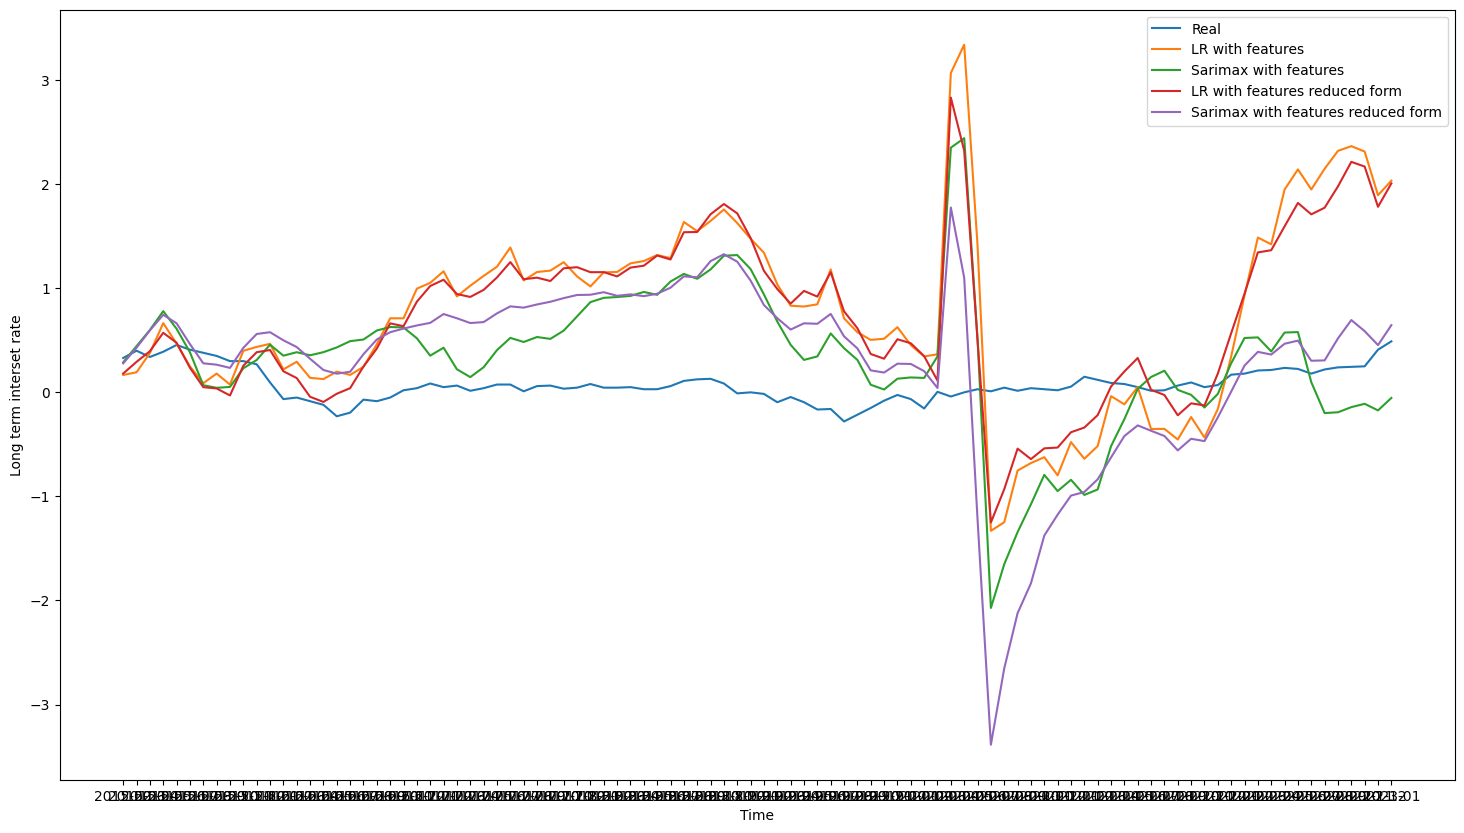

In [200]:
x_axis = test.index
plt.figure(figsize=(18, 10))
plt.plot(x_axis, y_test, label = 'Real')
plt.plot(x_axis, forec_Mod1, label = 'LR with features')
plt.plot(x_axis, forec_Mod2, label = 'Sarimax with features')
plt.plot(x_axis, forec_Mod3, label = 'LR with features reduced form')
plt.plot(x_axis, forec_Mod4, label = 'Sarimax with features reduced form')
plt.xlabel('Time'); plt.ylabel('Long term interset rate');
plt.legend();